<a href="https://colab.research.google.com/github/AhmadJamal01/Floodead-Inside/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GANs

## Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

## Read the Data

In [26]:
! rm -r gan_images/

rm: cannot remove 'gan_images/': No such file or directory


In [15]:
from google.colab import drive
import zipfile

# Mount your Google Drive
# drive.mount('/content/drive')

# Specify the path to your zip file in Google Drive
zip_path = '/content/drive/MyDrive/dataset.zip'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/') 
 


## Generator

In [3]:
# Define the generator architecture
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

## Discriminator

In [4]:
# Define the discriminator architecture
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(torch.prod(torch.tensor(img_shape))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

## Configuration

In [27]:
# Speed ups
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seed for reproducibility
torch.manual_seed(42)

## Model

In [32]:
# Set parameters
latent_dim = 100 # the dimensionality of the input noise vector
img_size = 64
img_channels = 3
batch_size = 32
img_shape = (img_channels, img_size, img_size)
num_epochs = 100
sample_interval = 15

# Initialize generator and discriminator
generator = Generator(latent_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)

# Define loss function and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


## Data Loader

In [17]:
# Create directory for generated images
os.makedirs('gan_images', exist_ok=True)

# Define transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * img_channels, std=[0.5] * img_channels)
])

# Load the dataset
# Access the extracted files
path = '/content/dataset/' 
dataset = ImageFolder(root=path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# train, validation, test = torch.utils.data.random_split(dataset, (0.2, 0.4, 0.4))
# dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)


## Training

In [33]:
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)

        # Configure input
        real_imgs = imgs.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.size(0), latent_dim).to(device)

        # Generate a batch of images
        fake_imgs = generator(z)

        # Measure discriminator's ability to classify real and fake images
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # Backward pass and optimize
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.size(0), latent_dim).to(device)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Measure generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        # Backward pass and optimize
        g_loss.backward()
        optimizer_G.step()

        # Print progress
        if (i + 1) % sample_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(dataloader)}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
            # Save generated images
            print("Saving...")
            save_image(gen_imgs.data[:25], f"gan_images/{epoch+1}_{i+1}.png", nrow=5, normalize=True)


Epoch [1/100]
Epoch [1/100], Batch [15/15], D_loss: 0.4832, G_loss: 0.7080
Saving...
Epoch [2/100]
Epoch [2/100], Batch [15/15], D_loss: 0.3700, G_loss: 0.9155
Saving...
Epoch [3/100]
Epoch [3/100], Batch [15/15], D_loss: 0.4142, G_loss: 0.9912
Saving...
Epoch [4/100]
Epoch [4/100], Batch [15/15], D_loss: 0.3880, G_loss: 0.8287
Saving...
Epoch [5/100]
Epoch [5/100], Batch [15/15], D_loss: 0.1598, G_loss: 1.5437
Saving...
Epoch [6/100]
Epoch [6/100], Batch [15/15], D_loss: 0.2526, G_loss: 1.0724
Saving...
Epoch [7/100]
Epoch [7/100], Batch [15/15], D_loss: 0.2560, G_loss: 1.0390
Saving...
Epoch [8/100]
Epoch [8/100], Batch [15/15], D_loss: 0.4606, G_loss: 0.7161
Saving...
Epoch [9/100]
Epoch [9/100], Batch [15/15], D_loss: 0.3628, G_loss: 0.8533
Saving...
Epoch [10/100]
Epoch [10/100], Batch [15/15], D_loss: 0.1824, G_loss: 1.2502
Saving...
Epoch [11/100]
Epoch [11/100], Batch [15/15], D_loss: 0.5099, G_loss: 0.7832
Saving...
Epoch [12/100]
Epoch [12/100], Batch [15/15], D_loss: 0.3011,

In [44]:
torch.save(generator.state_dict(), "generator_model.pth")


---

In [38]:
z = torch.randn(imgs.size(0), latent_dim).to(device)

# Generate a batch of images
gen_imgs = generator(z)

# Save generated images
print("Saving...")
save_image(gen_imgs.data[:imgs.size(0)], f"gan_images/test.png", nrow=5, normalize=True)
print("Saved")



Saving...
Saved


In [49]:
# Assuming the generator is already trained and saved
generator = Generator(latent_dim, img_shape).to(device)
generator.load_state_dict(torch.load('generator_model.pth'))
generator.eval()  # Set the generator to evaluation mode


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=12288, bias=True)
    (12): Tanh()
  )
)

In [50]:
# Sample noise vector
z = torch.randn(batch_size, latent_dim).to(device)

# Generate images
with torch.no_grad():
    generated_imgs = generator(z)

# Convert generated images to numpy array
generated_imgs = generated_imgs.cpu().numpy()

# Save generated images
# print("Saving...")
# save_image(generated_imgs.data[:imgs.size(0)], f"gan_images/test.png", nrow=5, normalize=True)
# print("Saved")

# Process or visualize the generated images as needed


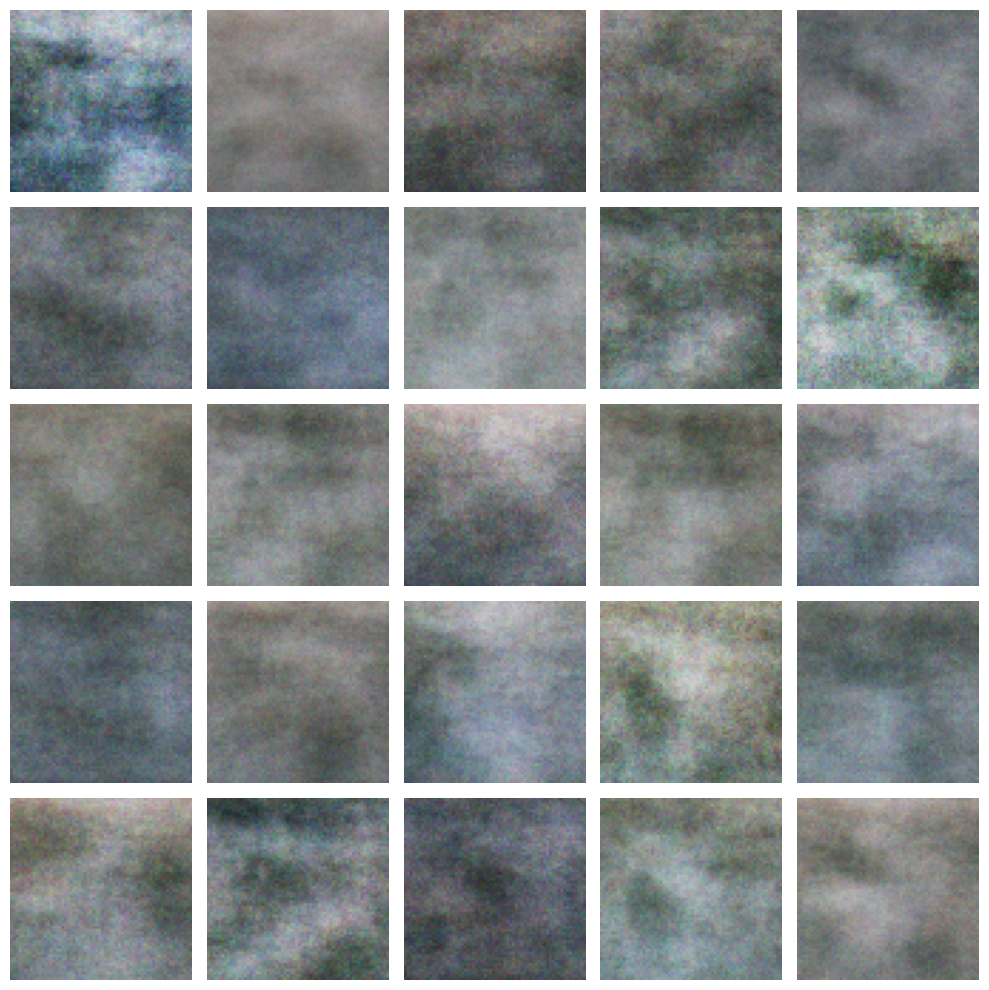

In [51]:
import matplotlib.pyplot as plt

# Rescaling Pixel Values: 
# Rescales the pixel values of the generated images from the range [-1, 1] to [0, 1]. 
# This is necessary because the generator outputs images with pixel values in the range [-1, 1] due to the Tanh activation function.
generated_imgs = (generated_imgs + 1) / 2.0

# Create a grid of images
rows = 5
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

# Iterate over the grid and plot the generated images
for i, ax in enumerate(axes.flatten()):
    img = generated_imgs[i]
    ax.imshow(img.transpose(1, 2, 0))
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()
